In [9]:
# ========================
# 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

PROC = Path('data/processed')
MODELS = Path('models')
MODELS.mkdir(exist_ok=True, parents=True)

In [10]:
# ========================
# 2. Load Processed Datasets
# ========================
train = pd.read_csv(PROC / 'train.csv')
val = pd.read_csv(PROC / 'val.csv')
test = pd.read_csv(PROC / 'test.csv')

print('Train:', train.shape, '| Val:', val.shape, '| Test:', test.shape)

Train: (722, 19) | Val: (128, 19) | Test: (150, 19)


In [11]:
# ========================
# 3. Helper: Feature Engineering Function
# ========================

def add_rule_features(df):
    """Add agronomic rule-based features that help ML learn better."""
    df = df.copy()
    df['High_N_Need'] = (df['Nitrogen_Level'] < 100).astype(int)
    df['High_P_Need'] = (df['Phosphorus_Level'] < 30).astype(int)
    df['High_K_Need'] = (df['Potassium_Level'] < 100).astype(int)
    return df

In [12]:
# ========================
# 4. Define Target and Features
# ========================

X_train_clf = train.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_train_clf = train['Fertilizer_Type']

X_val_clf = val.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_val_clf = val['Fertilizer_Type']

X_train_reg = X_train_clf.copy()
y_train_reg = train['Recommended_Quantity_kg_per_acre']

X_val_reg = X_val_clf.copy()
y_val_reg = val['Recommended_Quantity_kg_per_acre']

# Add engineered features consistently
X_train_clf = add_rule_features(X_train_clf)
X_val_clf = add_rule_features(X_val_clf)
X_train_reg = add_rule_features(X_train_reg)
X_val_reg = add_rule_features(X_val_reg)

In [13]:
# ========================
# 5. Handle Class Imbalance
# ========================
print("Before balancing:")
print(y_train_clf.value_counts(normalize=True))

max_count = y_train_clf.value_counts().max()
frames = []

for fert_type, subset in train.groupby('Fertilizer_Type'):
    subset_up = resample(subset, replace=True, n_samples=max_count, random_state=42)
    frames.append(subset_up)

train_balanced = pd.concat(frames)

print("\nAfter balancing:")
print(train_balanced['Fertilizer_Type'].value_counts())

X_train_clf = train_balanced.drop(['Fertilizer_Type','Recommended_Quantity_kg_per_acre'], axis=1)
y_train_clf = train_balanced['Fertilizer_Type']

# Add rule-based features again (since we recreated X_train_clf)
X_train_clf = add_rule_features(X_train_clf)

Before balancing:
Fertilizer_Type
Potash     0.33795
Mixed      0.17590
Urea       0.16759
DAP        0.16759
Compost    0.15097
Name: proportion, dtype: float64

After balancing:
Fertilizer_Type
Compost    244
DAP        244
Mixed      244
Potash     244
Urea       244
Name: count, dtype: int64


In [20]:
# ========================
# 5.5 Save final feature column order
# ========================
from pathlib import Path
import joblib

# Go one level up from notebooks/
MODELS = Path('../models')
MODELS.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Identify final feature columns used for training
final_features = X_train_clf.columns.tolist()

# Save the list
joblib.dump(final_features, MODELS / 'feature_columns.pkl')

print(f"✅ Saved final feature column order to: {MODELS.resolve() / 'feature_columns.pkl'}")


✅ Saved final feature column order to: C:\Users\sasik\OneDrive\Desktop\AIML Project\models\feature_columns.pkl


In [14]:
# ========================
# 6. Train Improved Random Forest Models
# ========================

clf_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=16,
    class_weight='balanced',
    random_state=42
)
reg_rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=14,
    random_state=42
)

clf_rf.fit(X_train_clf, y_train_clf)
reg_rf.fit(X_train_reg, y_train_reg)

preds_clf_rf = clf_rf.predict(X_val_clf)
preds_reg_rf = reg_rf.predict(X_val_reg)

print('✅ Balanced Random Forest Results')
print('Classification Accuracy:', accuracy_score(y_val_clf, preds_clf_rf))
print('Classification Report:\n', classification_report(y_val_clf, preds_clf_rf))

mae = mean_absolute_error(y_val_reg, preds_reg_rf)
r2 = r2_score(y_val_reg, preds_reg_rf)
print(f'Regression MAE: {mae:.2f}')
print(f'Regression R²: {r2:.3f}')


✅ Balanced Random Forest Results
Classification Accuracy: 0.1875
Classification Report:
               precision    recall  f1-score   support

     Compost       0.12      0.11      0.11        18
         DAP       0.27      0.17      0.21        23
       Mixed       0.17      0.22      0.19        18
      Potash       0.25      0.23      0.24        48
        Urea       0.11      0.14      0.12        21

    accuracy                           0.19       128
   macro avg       0.18      0.18      0.18       128
weighted avg       0.20      0.19      0.19       128

Regression MAE: 47.62
Regression R²: -0.021


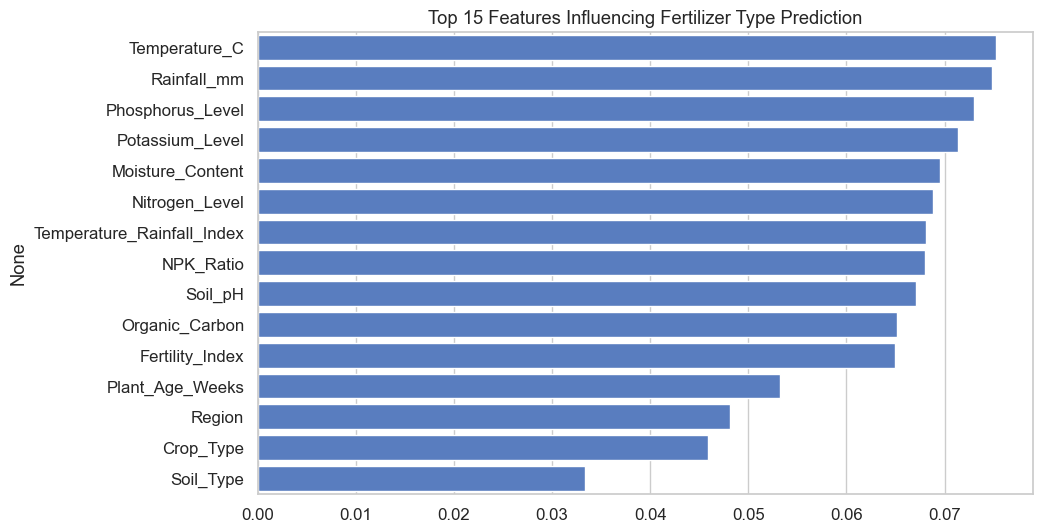

In [15]:
# ========================
# 7. Feature Importance Visualization
# ========================
importances = pd.Series(clf_rf.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title('Top 15 Features Influencing Fertilizer Type Prediction')
plt.show()

In [16]:
# ========================
# 8. Save Balanced Models
# ========================
joblib.dump(clf_rf, MODELS / 'fertilizer_type_model.pkl')
joblib.dump(reg_rf, MODELS / 'fertilizer_quantity_model.pkl')
print('✅ Balanced models saved successfully in models/.')

✅ Balanced models saved successfully in models/.


In [17]:
# ========================
# 9. Final Evaluation on Test Set
# ========================

X_test = test.drop(['Fertilizer_Type','Recommended_Quantity_kg_per_acre'], axis=1)
y_test_clf = test['Fertilizer_Type']
y_test_reg = test['Recommended_Quantity_kg_per_acre']

# Add rule-based features for test set
X_test = add_rule_features(X_test)

preds_clf_test = clf_rf.predict(X_test)
preds_reg_test = reg_rf.predict(X_test)

print('Test Accuracy (Classifier):', accuracy_score(y_test_clf, preds_clf_test))
print('Test MAE (Regressor):', mean_absolute_error(y_test_reg, preds_reg_test))

Test Accuracy (Classifier): 0.23333333333333334
Test MAE (Regressor): 46.015248994639336


In [18]:
# ========================
# 10. Save Evaluation Report
# ========================
reports_dir = Path('../reports')
reports_dir.mkdir(parents=True, exist_ok=True)

report = {
    'Classification_Accuracy': accuracy_score(y_test_clf, preds_clf_test),
    'Regression_MAE': mean_absolute_error(y_test_reg, preds_reg_test),
    'Regression_R2': r2_score(y_test_reg, preds_reg_test)
}

report_df = pd.DataFrame([report])
report_df.to_csv(reports_dir / 'final_evaluation_balanced.csv', index=False)

print(f"✅ Final evaluation metrics saved to: {reports_dir.resolve() / 'final_evaluation_balanced.csv'}")

✅ Final evaluation metrics saved to: C:\Users\sasik\OneDrive\Desktop\AIML Project\reports\final_evaluation_balanced.csv
